In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

<h4>initialize_dataset</h4>
Ładuje dane o studentach z pliku csv i zamienia kolumny o wynikach z egzaminu na jedną kolumnę definiującą czy student zdał czy nie zdał egzaminu.

In [1]:
def initialize_dataset(input_file: str) -> tuple:
    dataframe = pd.read_csv(input_file)
    columns = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
    columns_names = ['gender', 'race', 'parent_ed', 'lunch', 'prep_course']
    dataframe  = pd.get_dummies(dataframe , columns=columns, prefix=columns_names, dtype=int)
    dataframe[['math score', 'reading score', 'writing score']] = dataframe[['math score', 'reading score', 'writing score']].astype(int)
    dataframe['passed'] = dataframe.apply(lambda row: 1 if (row['math score'] > 60) & (row['reading score'] > 60) & (row['writing score'] > 60) else -1, axis=1)
    dataframe.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)

    x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(['passed'], axis=1), dataframe['passed'], test_size=0.2, random_state=42)
    return (x_train.to_numpy(), y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy())

In [11]:
class SVM:
    def __init__(self, C=1.0, kernel='linear', gamma=0.1):
        self.C = C
        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None

        if kernel == 'linear':
            self.kernel = self.linear_kernel
        else:
            self.kernel = self.rbf_kernel
            self.gamma = gamma

    def rbf_kernel(self, X1, X2):
        return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def linear_kernel(self, X1: np.array, X2: np.array):
        return np.dot(X1, X2.T)

    def fit(self, X, y, learning_rate=0.001, epochs=400):
        self.X = X
        self.y = y
        self.b = 0
        self.alpha = np.random.random(X.shape[0])
        self.ones = np.ones(X.shape[0])

        ker_ker = self.kernel(X, X)
        y_y = np.outer(y, y)
        yi_yj_k_k = y_y * ker_ker

        losses = []
        for _ in range(epochs):
            # gradient
            gradient = self.ones - yi_yj_k_k.dot(self.alpha)
            self.alpha = self.alpha + learning_rate * gradient

            # regularyzacja
            self.alpha = np.clip(self.alpha, 0, self.C)


            # funkcja straty
            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * yi_yj_k_k)
            losses.append(loss)

            # warunek zatrzymania
            if np.abs(np.dot(y.T, self.alpha)) < 1e-5:
                break


        indexes = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        b_i = y[indexes] - (self.alpha * y).dot(self.kernel(X, X[indexes]))
        self.b = np.mean(b_i)
        return losses

    def decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    def predict(self, X):
        return np.sign(self.decision_function(X))

In [5]:
def draw_losses_graph(losses: list):
    plt.plot(losses)
    plt.title("loss per epochs")
    plt.show()

In [20]:
def draw_metrics_graph(kernel="linear"):
    x_train, y_train, x_test, y_test = initialize_dataset("exams.csv")
    regularization_params = np.linspace(0.1, 1, 10)
    num_of_runs = 10
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    for param in regularization_params:
        temp_accuracy = 0
        temp_precision = 0
        temp_recall = 0
        for _ in range(num_of_runs):
            svm = SVM(C=param, kernel=kernel)
            svm.fit(x_train, y_train, learning_rate=0.001)
            prediction = svm.predict(x_test)
            temp_accuracy += accuracy_score(y_test, prediction)
            temp_precision += precision_score(y_test, prediction)
            temp_recall += recall_score(y_test, prediction)
        accuracy_scores.append(temp_accuracy / num_of_runs)
        precision_scores.append(temp_precision / num_of_runs)
        recall_scores.append(temp_recall / num_of_runs)

    plt.plot(regularization_params, accuracy_scores, label="accuracy")
    plt.plot(regularization_params, precision_scores, label="precision")
    plt.plot(regularization_params, recall_scores, label="recall")
    plt.legend()
    plt.title(f"metrics for {kernel} kernel")
    plt.show()

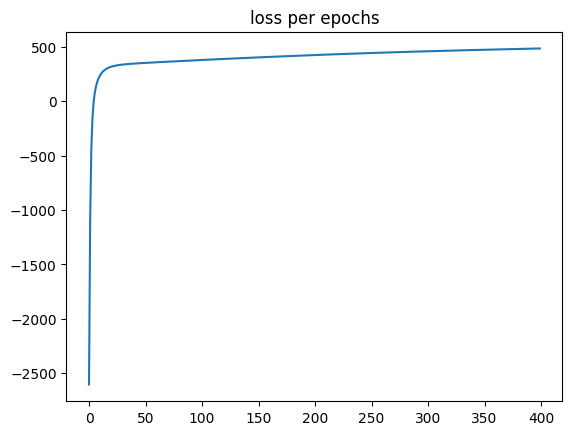

linear accuracy: 0.705
linear precision: 0.7175572519083969
linear recall: 0.8103448275862069
linear confusion Matrix:
 [[47 37]
 [22 94]]


In [13]:
x_train, y_train, x_test, y_test = initialize_dataset("exams.csv")

svm = SVM(C=1.0, kernel='linear')
losses =svm.fit(x_train, y_train, learning_rate=0.001)
draw_losses_graph(losses)
prediction = svm.predict(x_test)

print("linear accuracy:", accuracy_score(y_test, prediction))
print("linear precision:", precision_score(y_test, prediction))
print("linear recall:", recall_score(y_test, prediction))
print("linear confusion Matrix:\n", confusion_matrix(y_test, prediction))

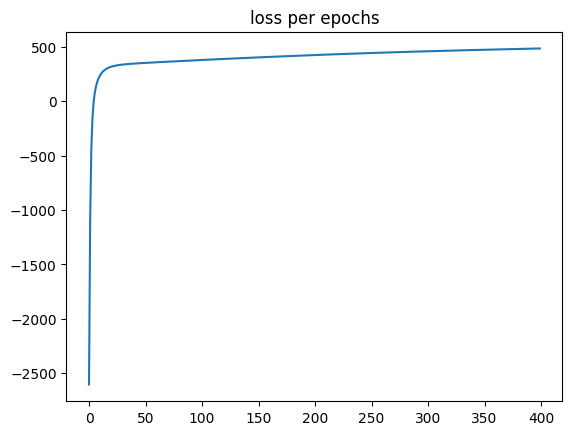

rbf accuracy: 0.7
rbf precision: 0.7222222222222222
rbf recall: 0.7844827586206896
rbf confusion Matrix:
 [[49 35]
 [25 91]]


In [14]:
svm = SVM(C=1.0, kernel="linear")
losess = svm.fit(x_train, y_train, learning_rate=0.001, epochs=1000)
prediction = svm.predict(x_test)
draw_losses_graph(losses)

print("rbf accuracy:", accuracy_score(y_test, prediction))
print("rbf precision:", precision_score(y_test, prediction))
print("rbf recall:", recall_score(y_test, prediction))
print("rbf confusion Matrix:\n", confusion_matrix(y_test, prediction))

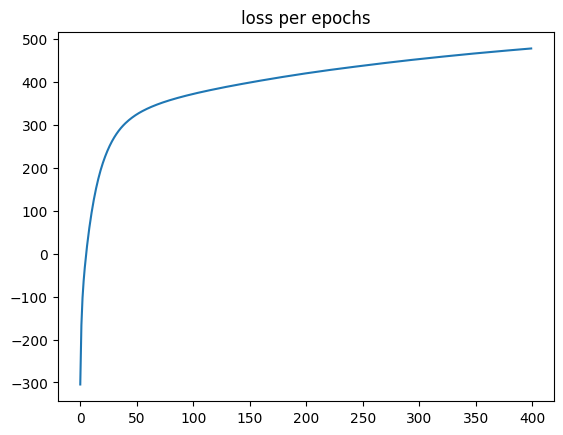

rbf accuracy: 0.675
rbf precision: 0.7107438016528925
rbf recall: 0.7413793103448276
rbf confusion Matrix:
 [[49 35]
 [30 86]]


In [8]:
svm = SVM(C=1.0, kernel="rbf")
losses = svm.fit(x_train, y_train, learning_rate=0.001)
prediction = svm.predict(x_test)
draw_losses_graph(losses)

print("rbf accuracy:", accuracy_score(y_test, prediction))
print("rbf precision:", precision_score(y_test, prediction))
print("rbf recall:", recall_score(y_test, prediction))
print("rbf confusion Matrix:\n", confusion_matrix(y_test, prediction))

Jak widać zwiększając liczbę epok ponad dwukrotnie jego dokładność prawie nie wzrosła, zatem nie ma sensu zwiększać bardziej liczby epok.

Wyniki metryk są niemal identyczne dla modelu używającego jądra liniowego jak i rbf, mimo, ze funkcja straty miala poczatkowo mniejsze wartosci
dla modelu z jadrem liniowym. Ale mimo tego szybciej osiągnął on lepsze wyniki.



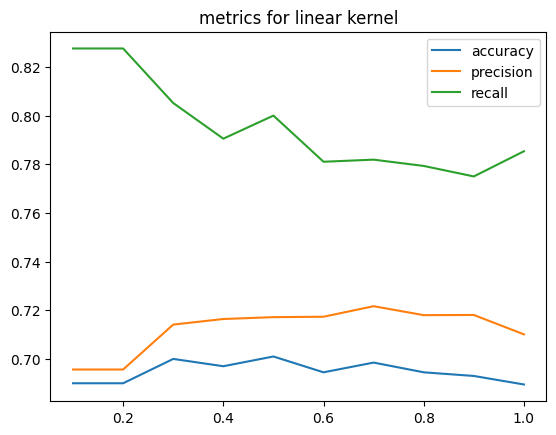

In [21]:
draw_metrics_graph("linear")

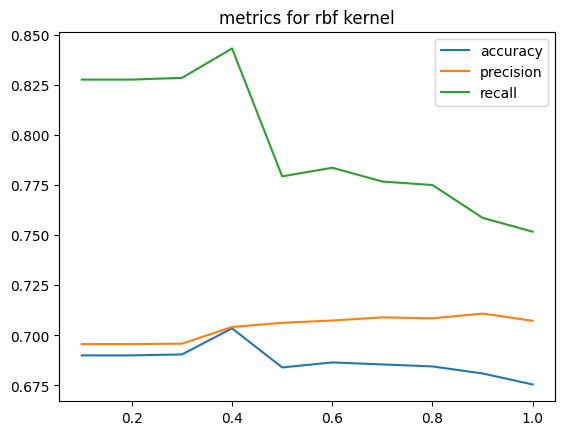

In [22]:
draw_metrics_graph("rbf")

Dla jądra linearnego jak i rbf wartości metryk są podobne, jednak dla jądra linearnego wzrost precyzji i czułości jest większy przy zwiększeniu parametru C niż dla rbf

Dla obu jąder dokładność jak i czułość zaczyna spadać przy za wysokich parametrach regularyzacji, ale dla rbf spadek jest większy.